# Extract Data from yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = yf.download('TSLA', 
                  start='2019-01-01', 
                  end='2024-4-29', 
                  progress=False)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600
2024-04-23,143.330002,147.259995,141.110001,144.679993,144.679993,124545100
2024-04-24,162.839996,167.970001,157.509995,162.130005,162.130005,181178000
2024-04-25,158.960007,170.880005,158.360001,170.179993,170.179993,126427500
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,109815700


In [3]:
df['Date'] = df.index  # Create a new column 'Date' with the index values
df.reset_index(drop=True, inplace=True) 

In [4]:
close_df = df[['Date', 'Close']]

In [5]:
close_df.head()

,Date,Close
0,2019-01-02,20.674667
1,2019-01-03,20.024000
2,2019-01-04,21.179333
3,2019-01-07,22.330667
4,2019-01-08,22.356667


# Create a Window Function 

In [6]:
def window(df, column_name, k):
    df_copy = df.copy()  
    for i in range(1, k + 1):
        new_column_name = f"{column_name}-{i}"
        df_copy[new_column_name] = df_copy[column_name].shift(i)
    # Swap column names
    column_names = list(df_copy.columns)
    return df_copy.iloc[:, ::-1].drop(range(k))

window_size = 7
close_df = window(close_df, 'Close', window_size)
#close_df = close_df.drop(columns = ['Date'])
close_df.tail(10)


,Close-7,Close-6,Close-5,Close-4,Close-3,Close-2,Close-1,Close,Date
1329,171.110001,164.899994,172.979996,176.880005,171.759995,174.600006,171.050003,161.479996,2024-04-15
1330,164.899994,172.979996,176.880005,171.759995,174.600006,171.050003,161.479996,157.110001,2024-04-16
1331,172.979996,176.880005,171.759995,174.600006,171.050003,161.479996,157.110001,155.449997,2024-04-17
1332,176.880005,171.759995,174.600006,171.050003,161.479996,157.110001,155.449997,149.929993,2024-04-18
1333,171.759995,174.600006,171.050003,161.479996,157.110001,155.449997,149.929993,147.050003,2024-04-19
1334,174.600006,171.050003,161.479996,157.110001,155.449997,149.929993,147.050003,142.050003,2024-04-22
1335,171.050003,161.479996,157.110001,155.449997,149.929993,147.050003,142.050003,144.679993,2024-04-23
1336,161.479996,157.110001,155.449997,149.929993,147.050003,142.050003,144.679993,162.130005,2024-04-24
1337,157.110001,155.449997,149.929993,147.050003,142.050003,144.679993,162.130005,170.179993,2024-04-25
1338,155.449997,149.929993,147.050003,142.050003,144.679993,162.130005,170.179993,168.289993,2024-04-26


In [7]:
#close_df.set_index('Date', inplace=True)
close_df_copy = close_df.copy()
close_df_copy = close_df_copy.drop('Date', axis = 1)

In [8]:
X = close_df_copy.drop(columns = 'Close')
y = close_df_copy['Close'] 

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1, 1))

In [12]:
print(X.shape, y.shape)

(1332, 7) (1332,)


In [18]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

In [19]:
print(X_train.shape, X_test.shape)

(1065, 7) (267, 7)


In [20]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

def build_lstm():
    model = Sequential()
    model.add(InputLayer((window_size, 1)))
    model.add(LSTM(50, return_sequences=True))  
    model.add(Dropout(0.2)) 
    model.add(LSTM(50))  
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu')) 
    model.add(Dense(1, activation='linear'))  
    return model

#model.summary()

In [21]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(actual, forecast):
    
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast lists must be the same")
    
    absolute_errors = [abs(actual[i] - forecast[i]) for i in range(len(actual))]
    percentage_errors = [absolute_errors[i] / actual[i] * 100 for i in range(len(actual))]
    mape = sum(percentage_errors) / len(actual)
    
    return mape

In [27]:
import optuna
def objective(trial):
    
    
    learning_rate = trial.suggest_float('learning_rate', 0.0098, 0.012)
    #batch_size = trial.suggest_categorical('batch_size', [16,32])
    
    print('Learning Rate', learning_rate)
    #print('batch_size', batch_size)
    
    model = build_lstm()
    
    checkpoint = ModelCheckpoint(f'tesla_model_lstm/model_tesla_window_7_{learning_rate}.h5', save_best_only=True)
    model.compile(loss='mean_squared_error',optimizer= Adam(learning_rate=learning_rate))
    model.fit(X_train, y_train, batch_size=32,epochs=400, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint])

    model_load = load_model(f'tesla_model_lstm/model_tesla_window_7_{learning_rate}.h5')
    
    test_predictions = model_load.predict(X_test).flatten()
    test_predictions = np.expand_dims(test_predictions, axis=1)
    test_predictions = scaler_y.inverse_transform(test_predictions)
    
    #test_y = np.expand_dims(y_test, axis=1)
    y_test1 = scaler_y.inverse_transform(y_test)
        
    y_TEST = y_test1
    y_PRED = test_predictions
        
    #mae = mean_absolute_error(y_TEST[-256:], y_PRED[-256:])
    #RMSE = rmse(y_TEST[-256:], y_PRED[-256:])
    MAPE = calculate_mape(y_TEST[-256:], y_PRED[-256:])
    #r2 = r2_score(y_TEST[-256:], y_PRED[-256:])
    
    return MAPE

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 20)

trial = study.best_trial
print(trial)

[I 2024-05-14 17:39:39,045] A new study created in memory with name: no-name-077bbec3-26e0-4587-a75f-bf425eebad25


Learning Rate 0.011113062311601273
Epoch 1/400
34/34 [==============================] - 4s 31ms/step - loss: 0.0171 - val_loss: 0.0015
Epoch 2/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 3/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 4/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 9.5638e-04
Epoch 5/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 9.4790e-04
Epoch 6/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 7/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 8/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 7.3765e-04
Epoch 9/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 8.9284e-04
Epoch 10/400
34/34 [=============================

[I 2024-05-14 17:42:03,008] Trial 0 finished with value: 2.2745092401560125 and parameters: {'learning_rate': 0.011113062311601273}. Best is trial 0 with value: 2.2745092401560125.


Learning Rate 0.010392838514836371
Epoch 1/400
34/34 [==============================] - 4s 32ms/step - loss: 0.0262 - val_loss: 0.0017
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0029 - val_loss: 8.7923e-04
Epoch 3/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 8.5743e-04
Epoch 4/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 9.3015e-04
Epoch 5/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 6/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 7.5091e-04
Epoch 7/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 7.2713e-04
Epoch 8/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 8.2455e-04
Epoch 10/400
34/34 [=====================

[I 2024-05-14 17:44:27,388] Trial 1 finished with value: 2.296609778501537 and parameters: {'learning_rate': 0.010392838514836371}. Best is trial 0 with value: 2.2745092401560125.


Learning Rate 0.011562989111084726
Epoch 1/400
34/34 [==============================] - 3s 31ms/step - loss: 0.0244 - val_loss: 9.4729e-04
Epoch 2/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 9.8080e-04
Epoch 3/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 8.4856e-04
Epoch 4/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 8.3223e-04
Epoch 5/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 7.8396e-04
Epoch 6/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 9.0300e-04
Epoch 7/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 6.9698e-04
Epoch 8/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 6.3082e-04
Epoch 9/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 5.9532e-04
Epoch 10/400
34/34 [==========

[I 2024-05-14 17:46:50,108] Trial 2 finished with value: 2.284637437620966 and parameters: {'learning_rate': 0.011562989111084726}. Best is trial 0 with value: 2.2745092401560125.


Learning Rate 0.010645732663668563
Epoch 1/400
34/34 [==============================] - 4s 31ms/step - loss: 0.0286 - val_loss: 0.0041
Epoch 2/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 3/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 4/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 9.3500e-04
Epoch 5/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 6/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 8.5092e-04
Epoch 7/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 8.4873e-04
Epoch 8/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 8.3346e-04
Epoch 10/400
34/34 [==============================

[I 2024-05-14 17:49:15,267] Trial 3 finished with value: 2.2656906354282156 and parameters: {'learning_rate': 0.010645732663668563}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.01133892569352646
Epoch 1/400
34/34 [==============================] - 3s 31ms/step - loss: 0.0220 - val_loss: 0.0027
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 8.9980e-04
Epoch 3/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 9.0017e-04
Epoch 4/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 5/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 8.4944e-04
Epoch 6/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 8/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 6.5953e-04
Epoch 9/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 10/400
34/34 [==============================

[I 2024-05-14 17:51:38,069] Trial 4 finished with value: 2.286410464917205 and parameters: {'learning_rate': 0.01133892569352646}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.011767733305784284
Epoch 1/400
34/34 [==============================] - 3s 31ms/step - loss: 0.0409 - val_loss: 0.0029
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 3/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 4/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 5/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 6/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 7/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 8/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 10/400
34/34 [==============================] - 0s 10ms/ste

[I 2024-05-14 17:54:01,637] Trial 5 finished with value: 2.3316085510994777 and parameters: {'learning_rate': 0.011767733305784284}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.011614621932494835
Epoch 1/400
34/34 [==============================] - 4s 31ms/step - loss: 0.0279 - val_loss: 0.0011
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 3/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 4/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 8.4969e-04
Epoch 5/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 7.5397e-04
Epoch 6/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 7/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 9.4852e-04
Epoch 8/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 6.3624e-04
Epoch 10/400
34/34 [==============================

[I 2024-05-14 17:56:23,373] Trial 6 finished with value: 2.2885145651639203 and parameters: {'learning_rate': 0.011614621932494835}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.010644897960379048
Epoch 1/400
34/34 [==============================] - 3s 30ms/step - loss: 0.0258 - val_loss: 0.0036
Epoch 2/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0037 - val_loss: 9.4537e-04
Epoch 3/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 9.9956e-04
Epoch 4/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 5/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 7/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 7.9573e-04
Epoch 8/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 7.1855e-04
Epoch 10/400
34/34 [==============================] 

[I 2024-05-14 17:58:46,555] Trial 7 finished with value: 2.283943945293147 and parameters: {'learning_rate': 0.010644897960379048}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.010095194589168676
Epoch 1/400
34/34 [==============================] - 3s 31ms/step - loss: 0.0253 - val_loss: 0.0032
Epoch 2/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 3/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 9.2649e-04
Epoch 4/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 5/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0028 - val_loss: 0.0056
Epoch 6/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 9/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 10/400
34/34 [==============================] - 0s 10ms/ste

[I 2024-05-14 18:01:07,690] Trial 8 finished with value: 2.268993766694305 and parameters: {'learning_rate': 0.010095194589168676}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.010075106131706847
Epoch 1/400
34/34 [==============================] - 4s 32ms/step - loss: 0.0292 - val_loss: 0.0020
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 3/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 9.4473e-04
Epoch 4/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 5/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 6/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 7/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 9.8551e-04
Epoch 9/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 9.8412e-04
Epoch 10/400
34/34 [==============================] - 0s 1

[I 2024-05-14 18:03:30,761] Trial 9 finished with value: 2.297581469579536 and parameters: {'learning_rate': 0.010075106131706847}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.010791867264940842
Epoch 1/400
34/34 [==============================] - 3s 32ms/step - loss: 0.0400 - val_loss: 0.0058
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0012
Epoch 3/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 4/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 9.7477e-04
Epoch 5/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 6/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 7/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 9.4339e-04
Epoch 8/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 9/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 8.4403e-04
Epoch 10/400
34/34 [==============================] -

[I 2024-05-14 18:05:55,416] Trial 10 finished with value: 2.3157892885037032 and parameters: {'learning_rate': 0.010791867264940842}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.010320722205511432
Epoch 1/400
34/34 [==============================] - 3s 31ms/step - loss: 0.0170 - val_loss: 0.0010
Epoch 2/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 3/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 4/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 8.7434e-04
Epoch 5/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 7.7689e-04
Epoch 6/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 7.4991e-04
Epoch 7/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 8/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 6.7266e-04
Epoch 9/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 6.7906e-04
Epoch 10/400
34/34 [=========================

[I 2024-05-14 18:08:18,267] Trial 11 finished with value: 2.3036651015416254 and parameters: {'learning_rate': 0.010320722205511432}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.009946393989527008
Epoch 1/400
34/34 [==============================] - 4s 49ms/step - loss: 0.0366 - val_loss: 0.0016
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 3/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 4/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 5/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 6/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 7/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 8/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 9.4237e-04
Epoch 9/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 10/400
34/34 [==============================] - 0s 10ms

[I 2024-05-14 18:10:40,239] Trial 12 finished with value: 2.30167402847431 and parameters: {'learning_rate': 0.009946393989527008}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.010423638547381682
Epoch 1/400
34/34 [==============================] - 3s 31ms/step - loss: 0.0190 - val_loss: 0.0029
Epoch 2/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 3/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0026 - val_loss: 8.9132e-04
Epoch 4/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0065
Epoch 5/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 7.6311e-04
Epoch 6/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 6.8392e-04
Epoch 7/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 7.4558e-04
Epoch 8/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 6.7956e-04
Epoch 9/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 5.8058e-04
Epoch 10/400
34/34 [=====================

[I 2024-05-14 18:12:59,350] Trial 13 finished with value: 2.2746999683254985 and parameters: {'learning_rate': 0.010423638547381682}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.00982018730534266
Epoch 1/400
34/34 [==============================] - 3s 31ms/step - loss: 0.0161 - val_loss: 0.0010
Epoch 2/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 3/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 4/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 5/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 6/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 7.7255e-04
Epoch 7/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 8.1281e-04
Epoch 9/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 6.7491e-04
Epoch 10/400
34/34 [==============================] - 0s

[I 2024-05-14 18:15:22,628] Trial 14 finished with value: 2.288993307098868 and parameters: {'learning_rate': 0.00982018730534266}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.011041562044443277
Epoch 1/400
34/34 [==============================] - 4s 32ms/step - loss: 0.0312 - val_loss: 0.0017
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 3/400
34/34 [==============================] - 0s 13ms/step - loss: 0.0024 - val_loss: 9.0910e-04
Epoch 4/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 5/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 9.2171e-04
Epoch 6/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 9.9938e-04
Epoch 7/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 8/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 9.6023e-04
Epoch 9/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 7.2967e-04
Epoch 10/400
34/34 [=========================

[I 2024-05-14 18:17:47,358] Trial 15 finished with value: 2.2690511014164674 and parameters: {'learning_rate': 0.011041562044443277}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.010185921567613878
Epoch 1/400
34/34 [==============================] - 3s 31ms/step - loss: 0.0202 - val_loss: 0.0038
Epoch 2/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 3/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 4/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 8.5419e-04
Epoch 5/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 6/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 8.6885e-04
Epoch 7/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 8.5793e-04
Epoch 8/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 9/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/400
34/34 [==============================] - 0s 1

[I 2024-05-14 18:20:09,739] Trial 16 finished with value: 2.2776523201189547 and parameters: {'learning_rate': 0.010185921567613878}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.010627756854062788
Epoch 1/400
34/34 [==============================] - 3s 31ms/step - loss: 0.0286 - val_loss: 0.0024
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0034 - val_loss: 9.4338e-04
Epoch 3/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 4/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 5/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 6/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 8/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 7.5508e-04
Epoch 9/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 7.6431e-04
Epoch 10/400
34/34 [==============================] - 0

[I 2024-05-14 18:22:30,965] Trial 17 finished with value: 2.2734834137653066 and parameters: {'learning_rate': 0.010627756854062788}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.011993843952016614
Epoch 1/400
34/34 [==============================] - 4s 32ms/step - loss: 0.0498 - val_loss: 0.0013
Epoch 2/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 3/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 4/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0026 - val_loss: 9.6078e-04
Epoch 5/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 6/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 9.3458e-04
Epoch 7/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 9.7885e-04
Epoch 8/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 9/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0078
Epoch 10/400
34/34 [==============================] -

[I 2024-05-14 18:24:52,538] Trial 18 finished with value: 2.300667228411918 and parameters: {'learning_rate': 0.011993843952016614}. Best is trial 3 with value: 2.2656906354282156.


Learning Rate 0.01057525419805099
Epoch 1/400
34/34 [==============================] - 3s 32ms/step - loss: 0.0500 - val_loss: 0.0029
Epoch 2/400
34/34 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 3/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 4/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 5/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 6/400
34/34 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 7/400
34/34 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 9.7163e-04
Epoch 8/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 9/400
34/34 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 10/400
34/34 [==============================] - 0s 10ms/st

[I 2024-05-14 18:27:13,392] Trial 19 finished with value: 2.2874288336879656 and parameters: {'learning_rate': 0.01057525419805099}. Best is trial 3 with value: 2.2656906354282156.


FrozenTrial(number=3, state=TrialState.COMPLETE, values=[2.2656906354282156], datetime_start=datetime.datetime(2024, 5, 14, 17, 46, 50, 109008), datetime_complete=datetime.datetime(2024, 5, 14, 17, 49, 15, 267186), params={'learning_rate': 0.010645732663668563}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.012, log=False, low=0.0098, step=None)}, trial_id=3, value=None)


In [43]:
model_load = load_model(f'tesla_model_lstm/model_tesla_window_7_0.010645732663668563.h5')
    
test_predictions = model_load.predict(X_test).flatten()
test_predictions = np.expand_dims(test_predictions, axis=1)
test_predictions = scaler_y.inverse_transform(test_predictions)

#test_y = np.expand_dims(y_test, axis=1)
y_test1 = scaler_y.inverse_transform(y_test)
    
y_TEST = y_test1
y_PRED = test_predictions
    
mae = mean_absolute_error(y_TEST[-256:], y_PRED[-256:])
RMSE = rmse(y_TEST[-256:], y_PRED[-256:])
MAPE = calculate_mape(y_TEST[-256:], y_PRED[-256:])
r2 = r2_score(y_TEST[-256:], y_PRED[-256:])

print("Mean Absolute Error (MAE):", mae)
print("RMSE",RMSE)
print("MAPE", MAPE)
print("R2", r2)

9/9 [==============================] - 1s 13ms/step
Mean Absolute Error (MAE): 4.932563245296478
RMSE 6.732781305084631
MAPE [2.26569064]
R2 0.9679823411204913


In [45]:
y_PRED_all_ = [i[0] for i in y_PRED]
y_TEST_ = [i[0] for i in y_TEST]

In [32]:
test_results = pd.DataFrame(data={'Predicted':y_PRED_all_, 'Actuals':y_TEST_, 'Date': close_df['Date'].iloc[-267:]})

In [33]:
test_results

,Predicted,Actuals,Date
1072,194.912827,185.520004,2023-04-05
1073,186.168091,185.059998,2023-04-06
1074,185.734741,184.509995,2023-04-10
1075,184.335510,186.789993,2023-04-11
1076,187.052155,180.539993,2023-04-12
...,...,...,...
1334,144.900040,142.050003,2024-04-22
1335,141.801483,144.679993,2024-04-23
1336,143.329376,162.130005,2024-04-24
1337,159.304214,170.179993,2024-04-25


In [34]:
test_results = test_results.set_index('Date')

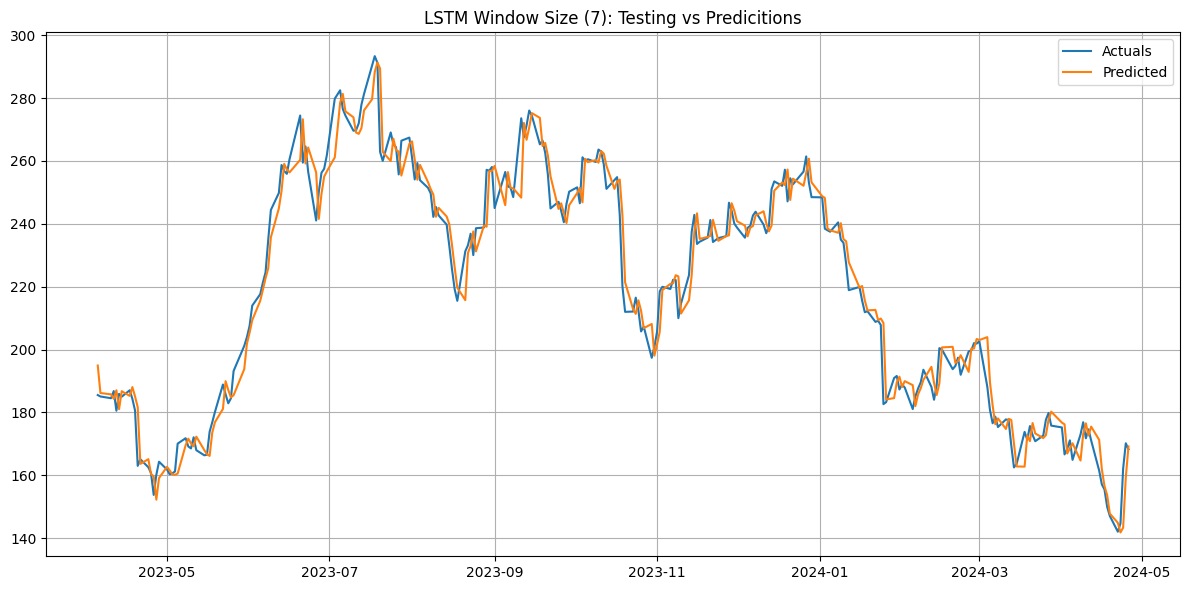

In [35]:
plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Actuals'], label = 'Actuals')
plt.plot(test_results['Predicted'], label = 'Predicted')

plt.title('LSTM Window Size (7): Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
# X_future = pd.DataFrame({'Close-7':close_df['Close-6'][-1:], 'Close-6':close_df['Close-5'][-1:],'Close-5':close_df['Close-4'][-1:],'Close-4':close_df['Close-3'][-1:], 
#                    'Close-3':close_df['Close-2'][-1:], 'Close-2':close_df['Close-1'][-1:], 'Close-1':close_df['Close'][-1:]})

In [ ]:
#X_future

In [36]:
X_future = pd.DataFrame()
column_name = 'Close'
close_df.drop(columns = 'Date', inplace = True)
for i in close_df.iloc[-1:].values:
    inverse_i = i[::-1][:-1]
    for j in range(6, -1, -1):
        new_column_name = f"{column_name}-{j+1}"
        X_future[new_column_name] = [inverse_i[j]]


In [37]:
X_future

,Close-7,Close-6,Close-5,Close-4,Close-3,Close-2,Close-1
0,149.929993,147.050003,142.050003,144.679993,162.130005,170.179993,168.289993


In [38]:
X_future_scaled = scaler_X.transform(X_future)

In [39]:
X_future_scaled

array([[0.34669662, 0.33946117, 0.32689957, 0.33350694, 0.37734694,
        0.39757107, 0.39282279]])

In [40]:
pred_future = model_load.predict(X_future_scaled)

1/1 [==============================] - 0s 54ms/step


In [41]:
pred_future_unscaled = scaler_y.inverse_transform(pred_future)

In [42]:
pred_future_unscaled

array([[169.65102]], dtype=float32)